# Prediction on the full timeseries data

In [1]:
import sys
sys.path.append("/home/joyneelm/approach-retreat") 
import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain
from os.path import join, exists, isfile 

from src.data import *
from sklearn.metrics import accuracy_score
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
from IPython import display
import time
%matplotlib inline

## Load the trained model

In [2]:
# model = tf.keras.models.load_model("models/emo_gru/rvAI_near_miss_1_trainsize_42_kfold_5_k_hidden_32_k_layers_3_batch_size_32_num_epochs_28_z_0.h5")
model = tf.keras.models.load_model("models/emo_gru/GRU_alldata.h5")

In [3]:
projpath = '/home/joyneelm/approach-retreat/'
subj = 'CON019'
rawpath = projpath+"/data/raw/"
interimpath = projpath+"/data/interim/"
raw_path = '/home/climbach/approach-retreat/data/raw'
processed_path = '/home/climbach/approach-retreat/data/processed'

yoked = pd.read_excel(join(raw_path,'CON_yoked_table.xlsx'), engine='openpyxl')
yoked = yoked.query('use == 1')

run_vars = ['run%s' % i for i in range(6)]
control = yoked[['control'] + run_vars]
uncontrol = yoked[['uncontrol'] + run_vars]
func_path = join(raw_path,'{subj}/{subj}_EP_TR_MNI_2mm_SI_denoised_NoBaseline.nii.gz')

with open(rawpath+"/{0}/regs_fancy/{0}_shock_onsets.txt".format(subj),"r") as f:
    f = f.readlines()

new_shock_onsets = []
for line in f:
    new_shock_onsets.append(line.replace('*',':'))
    
with open(interimpath+"{0}/{0}_shock_onsets.txt".format(subj),"w") as f:
    f.write(''.join(new_shock_onsets))

In [4]:
%%bash

subj=CON019
interimpath="/home/joyneelm/approach-retreat/data/interim/"

run_len='450 450 450 450 450 450'
# To use this make sure all '*' are replaced with ':' in the shock onset file
#timing_tool.py -timing data/external/${subj}/regs_fancy/${subj}_shock_onsets.txt -timing_to_1D data/external/${subj}/regs_fancy/${subj}_shock_ts.1D -tr 1.25 -min_frac 0.0001 -run_len $run_len

timing_tool.py -timing ${interimpath}/${subj}/${subj}_shock_onsets.txt \
    -timing_to_1D ${interimpath}/${subj}/${subj}_shock_ts.1D \
    -tr 0.0334 -min_frac 0.999 -run_len $run_len
#0.033333333334

In [5]:
mask= nil.image.load_img(join(processed_path,'masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz'))
rvAI = np.zeros_like(mask.get_fdata())
rvAI[np.logical_or(mask.get_fdata() == 230,mask.get_fdata() == 231)] = 1
rvAI = nil.image.new_img_like(mask,rvAI)

In [6]:
# Import timeseries
cortical = np.loadtxt(interimpath+"/{subj}/{subj}_cortical_meanTS.1D".format(subj=subj))
subcortical = np.loadtxt(interimpath+"/{subj}/{subj}_subcortical_meanTS.1D".format(subj=subj))

# loading whole-brain timeseries data
func = nil.image.load_img(func_path.format(subj=subj))
# Extract time-series only from right ventral-anterior insula 
whole_brain_ts = apply_mask(func,rvAI)
# print(rvAI_ts.shape)
# whole_brain_ts = np.hstack([cortical, subcortical])
# print(whole_brain_ts.shape)
runs = [(X - X.mean(axis=0))/X.std(axis=0) for X in np.split(whole_brain_ts,6,axis=0)]
whole_brain_ts = np.vstack(runs)[None,3:-1,:]
print(whole_brain_ts.shape)

#shock_flags = np.loadtxt('data/external/{subj}/regs_fancy/{subj}_shock_ts.1D'.format(subj=subj))
shock_flags = np.loadtxt(interimpath+"{subj}/{subj}_shock_ts.1D".format(subj=subj))[:-150] # 4*1.25*30 = 150
exp_df = pd.read_csv(rawpath+"{subj}/regs_fancy/{subj}_all_regs.txt".format(subj=subj),sep='\t',index_col=0)
#exp_df['shock_flags'] = shock_flags
proximity = exp_df.iloc[:,0].values[:-4]
direction = exp_df['sign'].values[:-4]
direction[np.logical_and(direction!=-1.,direction!=1.)] = 0.
censor15 = exp_df['censor15'].values[:-4]
sblock = exp_df['sblock'].values[:-4]

(1, 2156, 745)


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

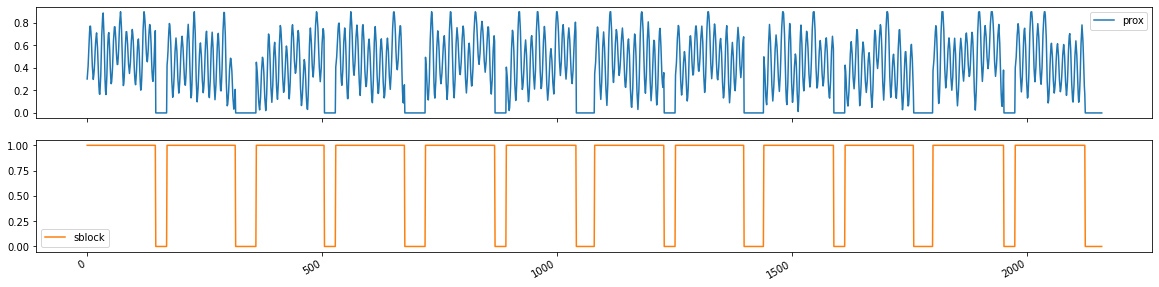

In [7]:
exp_df.loc[:,['prox','sblock']].plot(subplots=True,figsize=(20,5))

## Predict

In [8]:
predictions = []
for ts in range(proximity.shape[0]-7):
    ts_window = whole_brain_ts[:,ts:ts+7,:]
#     print(model.predict_classes(ts_window).shape)
    predictions.append('retreat' if model.predict_classes(ts_window)[0][-1] == 0 else 'approach')
    #predictions.append('retreat' if model.predict(ts_window)[0][-1] > 0.5 else 'approach')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [9]:
predictions = np.array(predictions)
predictions.shape

(2149,)

In [10]:
prepended_predictions = np.hstack([np.array([predictions[0]]*7), predictions])
print('Length of prediction array: ',len(prepended_predictions))
print('Length of proximity array: ',len(proximity))

Length of prediction array:  2156
Length of proximity array:  2156


(80693, 6)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

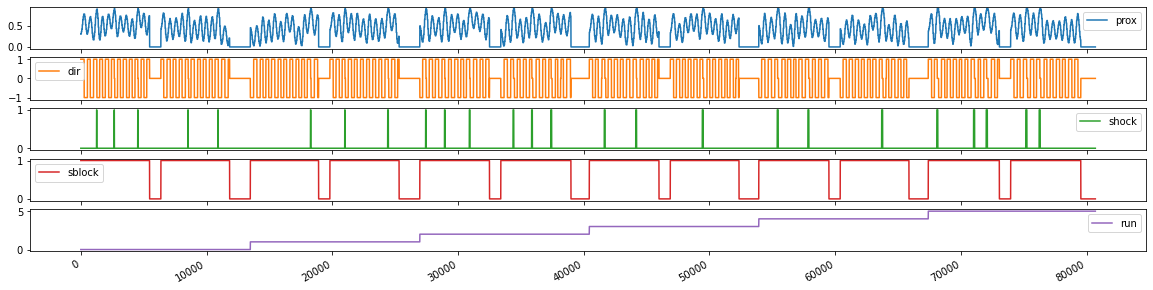

In [11]:
pred_df = pd.DataFrame([prepended_predictions,proximity,direction,sblock,exp_df['run'].values[:-4]],
                       index=['Predictions','prox','dir','sblock','run'],
                       columns=np.arange(len(prepended_predictions))*1.25).T

pred_df.index.name = 'time'
pred_df.index = pd.to_datetime(pred_df.index,unit='s')
pred_df = pred_df.resample('33.383L').pad()
pred_df['shock'] = shock_flags[:shock_flags.shape[0]-1]
print(pred_df.shape)
pred_df[['prox','dir','shock','sblock','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

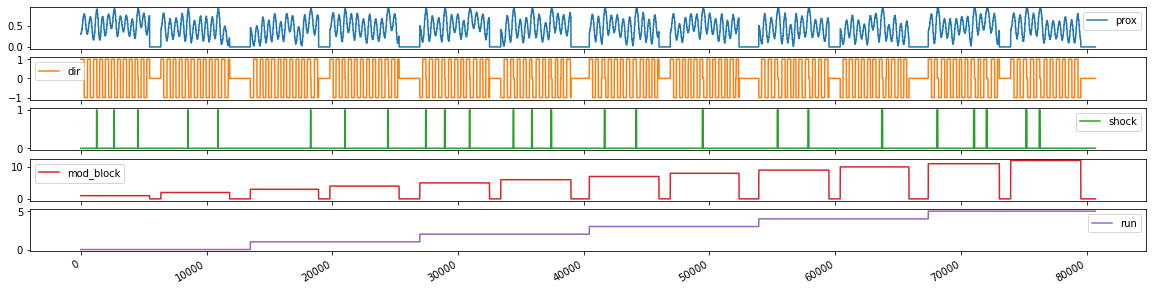

In [12]:
# Add modulated block column so each block can be identified
boxcar = pred_df['sblock']
mod_boxcar = boxcar.copy()
block_num = 1
for i in range(len(boxcar)-1):
    if boxcar[i] == 0. and boxcar[i+1] == 1.:
        block_num += 1
    mod_boxcar[i] = boxcar[i]*block_num
    
pred_df['mod_block'] = mod_boxcar
pred_df[['prox','dir','shock','mod_block','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

Shape:  (2694, 7)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

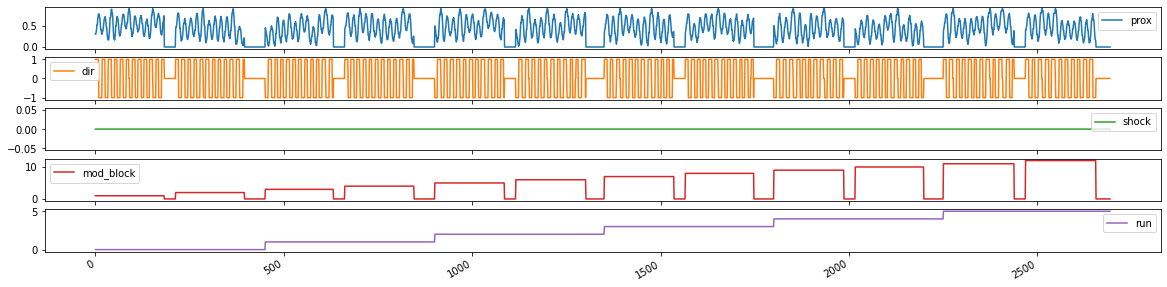

In [13]:
## filter out shocks
pred_df = pred_df[pred_df['shock']==0.0]
pred_df = pred_df.resample('1S').pad()
print('Shape: ',pred_df.shape)
pred_df[['prox','dir','shock','mod_block','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

In [14]:
whole_brain_ts.shape

(1, 2156, 745)

In [15]:
# Single Block
def get_block(pred_df, run_num, block_num):
    block_df = pred_df[(pred_df['mod_block']==block_num) & (pred_df['run']==run_num)] # Duration of first run, first block in CON054 is 180s, so roundup(30*180) samples 
    return block_df

In [16]:
from collections import defaultdict
blocks = defaultdict(dict)
for run_num in range(6):
    for block_num in range(1,3):
        b_num = block_num + 2*run_num
        block = get_block(pred_df,run_num,b_num)
        blocks['run%i' %(run_num)]['bl%i' %(block_num-1)] = block
        print('Run %i, block %i: %i' %(run_num, b_num, block.shape[0]))

Run 0, block 1: 183
Run 0, block 2: 183
Run 1, block 3: 181
Run 1, block 4: 184
Run 2, block 5: 185
Run 2, block 6: 186
Run 3, block 7: 185
Run 3, block 8: 182
Run 4, block 9: 186
Run 4, block 10: 182
Run 5, block 11: 188
Run 5, block 12: 187


In [17]:
if not os.path.isdir(projpath+'/data/psychopy/{subj}'.format(subj=subj)):
    os.makedirs(projpath+'/data/psychopy/{subj}'.format(subj=subj))

for r, run in enumerate(blocks):
    for bl, block in enumerate(blocks[run]):
        preds = blocks[run][block].Predictions.values
        dirc = np.array(['approach' if d == 1.0 else 'retreat' for d in blocks[run][block].dir.values])
        if len(preds) < 5400:
            preds = np.append(preds,[preds[-1]]*(5400-len(preds)))
            dirc = np.append(dirc,[dirc[-1]]*(5400-len(dirc)))
        
        np.savetxt(projpath+'/data/psychopy/{subj}/subj{subj}_run{r}_bl{bl}_pred.txt'.format(subj=subj,
                                                                          r=r, bl=bl),
                   np.array(tuple(zip(preds[:5400],dirc[:5400]))),fmt='%s')
        

In [18]:
y = direction[7:]
print(np.unique(y))
non_zero_idx = y != 0
y = y[non_zero_idx]
print(np.unique(y))
y = (y == 1.).astype(np.float)
print(np.unique(y))

y_pred2 = (np.array(predictions)[non_zero_idx] == 'approach').astype(np.float)

[-1.  0.  1.]
[-1.  1.]
[0. 1.]


## Observed vs. Chance Arruacy
Chance accuracy is defined as the accuracy if the majority is class is predicted all the time.

In [19]:
pd.DataFrame(y).value_counts()

1.0    863
0.0    858
dtype: int64

In [20]:
y.shape

(1721,)

In [21]:
y_pred2.shape

(1721,)

In [22]:
print(y[:300])
print(y_pred2[:300])

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 

In [23]:
print('Chance Accuracy: %.2f' %(accuracy_score(y,np.ones(y.shape))))
print('Observed Accuray: %.2f' %(accuracy_score(y,y_pred2)))

Chance Accuracy: 0.50
Observed Accuray: 0.60


## Check performace on the upsampled version

1it [00:00,  6.10it/s]

0
0


183it [00:33,  5.38it/s]
1it [00:00,  5.56it/s]

1


183it [00:34,  5.33it/s]
1it [00:00,  5.59it/s]

1
0


181it [00:34,  5.29it/s]
1it [00:00,  5.58it/s]

1


184it [00:33,  5.43it/s]
0it [00:00, ?it/s]

2
0


185it [00:34,  5.37it/s]
1it [00:00,  5.54it/s]

1


186it [00:35,  5.28it/s]
1it [00:00,  5.52it/s]

3
0


185it [00:35,  5.28it/s]
1it [00:00,  5.60it/s]

1


182it [00:33,  5.43it/s]
1it [00:00,  5.24it/s]

4
0


186it [00:35,  5.29it/s]
1it [00:00,  5.42it/s]

1


182it [00:33,  5.35it/s]
1it [00:00,  5.48it/s]

5
0


188it [00:35,  5.28it/s]
1it [00:00,  5.57it/s]

1


187it [00:34,  5.36it/s]


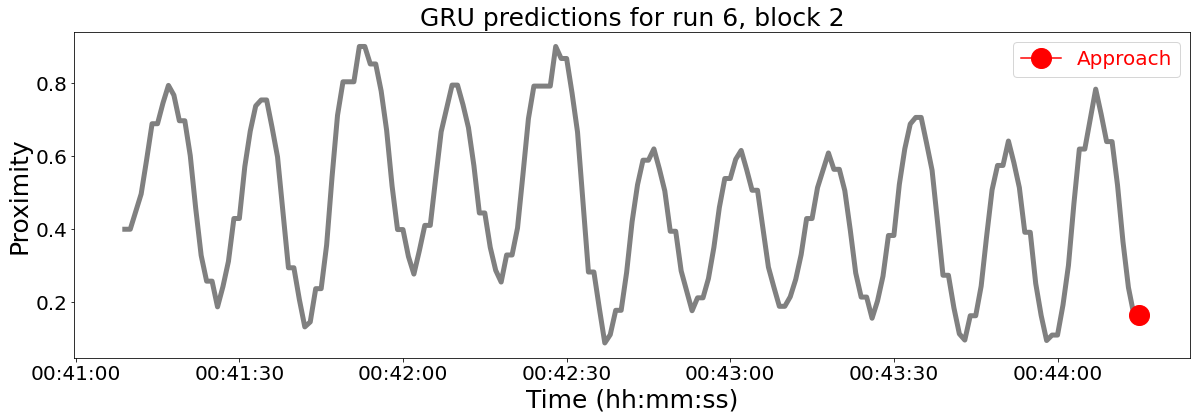

In [25]:
pl.figure(figsize=(20,6))
# pl.subplots_adjust(hspace=0.25)
counter = 0
from tqdm import tqdm
for run in range(6):
    print(run)
    for bl in range(2):
        print(bl)
        block = blocks[f'run{run}'][f'bl{bl}']
        for ii, row in tqdm(block.iloc[::1,:].iterrows()):

            if row['Predictions'] == 'approach':
                color1 ='red'
            else:
                color1= 'green'

            pl.clf()
            pl.plot(block.index, block['prox'], linewidth=5, c='grey')
            pl.plot(row.name,row['prox'],c=color1,marker='o',markersize=20,label=row['Predictions'].capitalize())
            pl.ylabel('Proximity',fontsize=25)
            pl.xlabel('Time (hh:mm:ss)',fontsize=25)
            pl.title(f'GRU predictions for run {run+1}, block {bl+1}',fontsize=25)
            pl.tick_params(axis='both', which='major', labelsize=20)
            pl.legend(fontsize=20, labelcolor=color1)
#             display.clear_output(wait=True)
#             display.display(pl.gcf())
            pl.savefig("figures/emo_gru/frame_{:04}.png".format(counter), dpi=100, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches=None, pad_inches=0.4,
            frameon=None, metadata=None)
            counter += 1
    #         time.sleep(1/10)


In [26]:
input_file = 'figures/emo_gru/frame_%04d.png'
output_file = f'figures/emo_gru/emo_gru_movie_CON019.mp4'
fm = 4

# create movie
!ffmpeg -y -framerate {fm} -i {input_file} -c:v libx264 -pix_fmt yuv420p {output_file}

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib